<h1>CNN for to detect brain tumors using MRI images</h1>

<h3>Этап 1</h3> Разделение данных

In [88]:
# Импорт необходимых библиотек
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [63]:
# Определяем пути к директориям и категории данных
DATA_DIR = "data/raw"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
TEST_DIR = "data/test"
categories = ["yes", "no"]


In [64]:
# Создание необходимых директорий
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(dir_path, category), exist_ok=True)

In [65]:
# Функция для разделения данных
def split_and_move_data(data_dir, train_dir, val_dir, test_dir, categories):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        
        # Разделение данных
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
        
        # Перемещение файлов
        for image_set, target_dir in [(train_images, train_dir), 
                                      (val_images, val_dir), 
                                      (test_images, test_dir)]:
            for image in image_set:
                shutil.copy(
                    os.path.join(category_path, image), 
                    os.path.join(target_dir, category, image)
                )


In [66]:
# Выполнение разделения данных
split_and_move_data(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, categories)
print("Данные успешно разделены!")


Данные успешно разделены!


<h3>Этап 2</h3>  Предобработка данных

In [67]:
# Параметры для изображений
img_size = (224, 224)

In [68]:
# Создание генераторов для данных
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [69]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [70]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [71]:
# Генерация данных из директорий
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'data/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


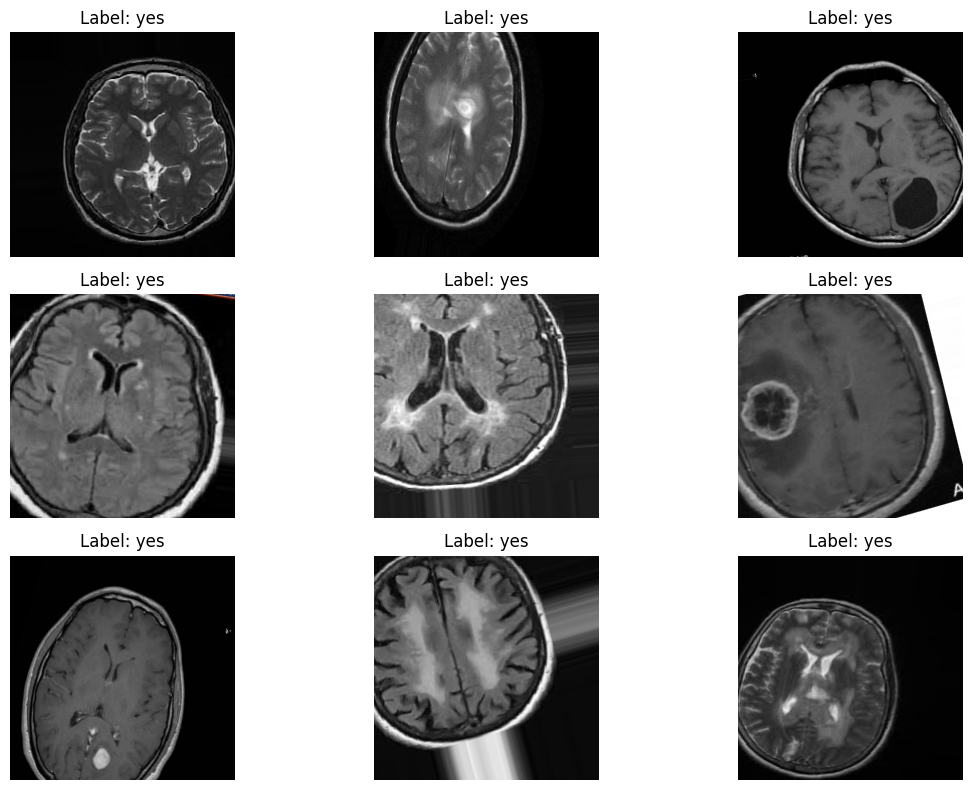

In [72]:
# Визуализация аугментаций
def visualize_augmentations(generator, category):
    # Получаем данные из генератора
    batch = next(generator)
    images, labels = batch
    plt.figure(figsize=(12, 8))
    
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {category}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Пример для категории "yes"
visualize_augmentations(train_generator, category="yes")


<h3>Этап 3</h3> Построение модели

In [89]:
# Создание модели CNN
model = Sequential([
    # Первый сверточный слой + BatchNormalization + LeakyReLU + MaxPooling
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Второй сверточный слой + BatchNormalization + LeakyReLU + MaxPooling
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Третий сверточный слой + BatchNormalization + LeakyReLU + MaxPooling
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Плоский слой перед полносвязным слоем
    Flatten(),
    
    # Полносвязный слой + BatchNormalization + LeakyReLU
    Dense(128),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.5),
    
    # Выходной слой
    Dense(1, activation='sigmoid')  # Сигмоида для бинарной классификации
])


In [91]:
# Компиляция модели с уменьшенным learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Добавление EarlyStopping для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [92]:
# Проверим структуру модели
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,497 (42.61 MB)

 Trainable params: 11,169,793 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

<h3>Этап 4</h3> Обучение модели

In [103]:
# Обучение модели
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Увеличьте количество эпох для лучшего обучения
    batch_size=8,  # Измените размер батча для оптимизации
    callbacks=[early_stopping]  # Используем EarlyStopping
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 638ms/step - accuracy: 0.6222 - loss: 0.8953 - val_accuracy: 0.6053 - val_loss: 0.6410
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 619ms/step - accuracy: 0.6793 - loss: 0.6830 - val_accuracy: 0.6053 - val_loss: 0.6628
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 612ms/step - accuracy: 0.6929 - loss: 0.7033 - val_accuracy: 0.6053 - val_loss: 0.6515
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 649ms/step - accuracy: 0.6041 - loss: 0.7523 - val_accuracy: 0.6053 - val_loss: 0.6371
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.6839 - loss: 0.5901 - val_accuracy: 0.6053 - val_loss: 0.6857
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 634ms/step - accuracy: 0.6830 - loss: 0.6641 - val_accuracy: 0.6053 - val_loss: 0.6981
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.6940 - loss: 0.6659 - val_accuracy: 0.6053 - val_loss: 0.6854
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step - accuracy: 0.6925 - loss: 0.5637 - val_accuracy: 0.

In [104]:
# Визуализация обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

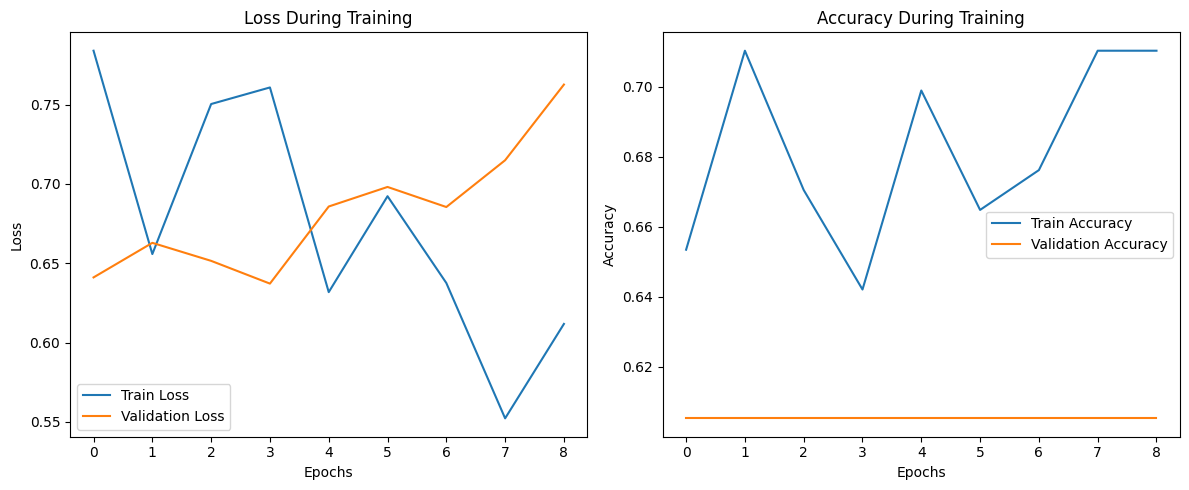

In [105]:
# Построение графиков
plot_training_history(history)